In [9]:
# Trinidad Marroquin
# qsq707

## Lab 6A

<em>Lab 6 consists of two exercises on natural language processing through conducting a sentiment analysis on text data.</em>

This exercise is to examine customer review data on airlines around the world and compare the reviews across major world airlines across Business Class, and Economy Class. We will not include First Class and Premium Economy as part of this analysis. We will compare the findings between the text-based reviews and the score-based reviews.

We will be using Skytrax (http://airlineequity.com) data scraped and wrangled by @Efehan on Kaggle (https://www.kaggle.com/efehandanisman/skytrax-airline-reviews). The CSV file has been provided for you. 

**Tasks**

1. Read ```capstone_airline_reviews3.csv``` into a Pandas dataframe. Note that this CSV file has blank lines that you will need to remove within the code. 

2. Analyze the data such that you can find the average polarity of all reviews for each airline's business class and economy class products. From the CSV file you, you will use the ```airline```, ```customer_review```, and ```cabin``` for this analysis. You are conducting a sentiment analysis (polarity only) on the ```customer_review``` data. Only include airlines that have more than 100 reviews for Business Class and more than 200 reviews for Economy Class and more than 500 reviews total. <em>There will only be 28 airlines that meet this requirement.</em> You should create a new ```DataFrame``` that holds the airline name, the average polarity for their business class reviews, and average polarity for their economy class reviews.
3. Plot a scatter plot to compare the ratings with x-axis for the average polarity values for Economy Class and the y-axis for the average polarity values for Business Class. Each dot on the scatter plot represents an airline. The size of the scatter plot should be related to the number of reviews the airline has. 
4. Select one airline and create a word cloud for each of its' business class, economy class, and all its reviews. The phrase ```âœ… Trip Verified |``` appears in front of every review, remove it. Then, conduct a visual analysis of what the most common words were in customers' reviews.
5. Answer the questions below. 

In [10]:
# Do all the imports
from textblob import TextBlob
import pandas as pd
import numpy as np
from PIL import Image
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import shutil
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

In [11]:
# Task 1
def load_csv_or_excel_file(file_path):
    """
    This function attempts to load the file as either a CSV or Excel file.
    It handles errors related to the file's existence, permissions, and format.
    """
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"The file at {file_path} does not exist.")
        
        # Check if file is readable
        if not os.access(file_path, os.R_OK):
            raise PermissionError(f"Permission denied: Cannot read the file at {file_path}.")
        
        # First, attempt to load it as a CSV file
        try:
            print(f"Attempting to load the file as CSV: {file_path}")
            df = pd.read_csv(file_path, skip_blank_lines=True)
            print("File loaded successfully as CSV.")
        except pd.errors.ParserError:
            # If parsing fails, attempt to load as Excel file
            print(f"Failed to load as CSV, attempting to load as Excel: {file_path}")
            df = pd.read_excel(file_path, engine='openpyxl')
            print("File loaded successfully as Excel.")

        # Remove rows where all elements are NaN (blank rows)
        df.dropna(how='all', inplace=True)

        # Check if the necessary columns are present
        required_columns = ['customer_review', 'overall', 'cabin']
        if not all(column in df.columns for column in required_columns):
            raise ValueError(f"Corrupted file: Missing one or more required columns: {required_columns}")

        print("File loaded and cleaned successfully.")
        return df

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
    except PermissionError as perm_error:
        print(f"Error: {perm_error}")
    except pd.errors.EmptyDataError:
        print("Error: No data found in the file. The file might be empty or malformed.")
    except pd.errors.ParserError:
        print("Error: Parsing issue encountered. The file may be corrupted or improperly formatted.")
    except ValueError as ve:
        print(f"Error: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        print("Finished attempting to load the file.")

# Load the file
file_path =  'capstone_airline_reviews3.csv'
df = load_csv_or_excel_file(file_path)

# If the DataFrame is successfully loaded, show the first few rows
if df is not None and not df.empty:
    print(df[['customer_review', 'overall', 'cabin']].head())

    # Optionally, save the cleaned data to a new file
    cleaned_file_path = 'cleaned_airline_reviews.csv'
    try:
        df.to_csv(cleaned_file_path, index=False)
        print(f"Cleaned data successfully saved to {cleaned_file_path}")
    except Exception as e:
        print(f"Error while saving the cleaned data: {e}")




Attempting to load the file as CSV: capstone_airline_reviews3.csv
File loaded successfully as CSV.
File loaded and cleaned successfully.
Finished attempting to load the file.
                                     customer_review  overall          cabin
1  âœ… Trip Verified | London to Izmir via Istanb...      7.0  Economy Class
3  âœ… Trip Verified | Istanbul to Bucharest. We ...      2.0  Economy Class
5  âœ… Trip Verified | Rome to Prishtina via Ista...      3.0  Economy Class
7  âœ… Trip Verified | Flew on Turkish Airlines I...     10.0  Economy Class
9  âœ… Trip Verified | Mumbai to Dublin via Istan...      1.0  Economy Class
Cleaned data successfully saved to cleaned_airline_reviews.csv


In [12]:
# Task 2
def check_and_download_vader_lexicon():
    """
    Checks if the VADER lexicon exists in the nltk data directory, and downloads it if necessary.
    """
    nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
    vader_lexicon_path = os.path.join(nltk_data_path, 'sentiment/vader_lexicon.zip')

    # Check if the VADER lexicon is already downloaded
    if not os.path.exists(vader_lexicon_path):
        print("VADER lexicon not found. Downloading...")
        # Specify the directory for nltk data
        nltk.data.path.append(nltk_data_path)
        nltk.download('vader_lexicon', download_dir=nltk_data_path)
    else:
        print("VADER lexicon already exists. Proceeding with analysis.")

def check_disk_space(min_required_space_gb=1):
    """
    Checks if there is enough disk space before performing operations that could require writing to disk.
    Returns True if enough space is available, otherwise False.
    """
    total, used, free = shutil.disk_usage("/")
    free_gb = free / (2**30)  # Convert bytes to gigabytes
    if free_gb < min_required_space_gb:
        return False
    return True

def sentiment_analysis_with_system_checks(df):
    """
    This function performs sentiment analysis on the customer reviews, filters the airlines based on review count conditions,
    and returns a DataFrame with average polarity for Business and Economy class reviews. 
    Includes error handling for system resources (memory, disk space) and data validation.
    """
    try:
        # Check and download the VADER lexicon if not already downloaded
        check_and_download_vader_lexicon()

        # Check for disk space before proceeding
        if not check_disk_space(min_required_space_gb=1):
            raise OSError("Not enough disk space to proceed with the analysis. Please free up some space.")

        # Initialize VADER sentiment analyzer
        sia = SentimentIntensityAnalyzer()

        # Check if the required columns exist in the dataframe
        required_columns = ['airline', 'customer_review', 'cabin']
        if not all(column in df.columns for column in required_columns):
            raise ValueError(f"Dataframe is missing one or more required columns: {required_columns}")

        # Filter out relevant columns
        df_filtered = df[['airline', 'customer_review', 'cabin']].dropna()

        # Check if there are any reviews to process after filtering
        if df_filtered.empty:
            raise ValueError("No valid data available after filtering for relevant columns.")

        # Only keep rows where 'cabin' is 'Business Class' or 'Economy Class'
        df_filtered = df_filtered[df_filtered['cabin'].isin(['Business Class', 'Economy Class'])]

        # If no valid rows remain, raise an error
        if df_filtered.empty:
            raise ValueError("No valid reviews for Business or Economy class.")

        # Apply sentiment analysis (VADER) to the customer_review column
        df_filtered['polarity'] = df_filtered['customer_review'].apply(lambda review: sia.polarity_scores(review)['compound'])

        # Count reviews per airline and class
        review_counts = df_filtered.groupby(['airline', 'cabin']).size().unstack(fill_value=0)

        # Filter airlines: more than 100 Business Class, more than 200 Economy Class, and more than 500 total reviews
        valid_airlines = review_counts[(review_counts['Business Class'] > 100) & 
                                       (review_counts['Economy Class'] > 200) &
                                       (review_counts.sum(axis=1) > 500)].index

        # If no airlines meet the review count criteria, raise an error
        if len(valid_airlines) == 0:
            raise ValueError("No airlines meet the review count criteria.")

        # Filter dataframe to only include valid airlines
        df_valid = df_filtered[df_filtered['airline'].isin(valid_airlines)]

        # Group by airline and cabin to calculate average polarity for Business and Economy class
        avg_polarity = df_valid.groupby(['airline', 'cabin'])['polarity'].mean().unstack()

        # Reset index to turn the MultiIndex into columns
        avg_polarity_df = avg_polarity.reset_index()

        # Rename the columns for clarity
        avg_polarity_df.columns = ['airline', 'average_business_polarity', 'average_economy_polarity']

        print("Sentiment analysis completed successfully.")
        return avg_polarity_df

    except MemoryError:
        print("Error: The system ran out of memory during the analysis. Consider increasing system memory or processing smaller datasets.")
    except OSError as os_error:
        print(f"System Error: {os_error}")
    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        print("Sentiment analysis process has been completed.")

# Call the function on the loaded data
result_df = sentiment_analysis_with_system_checks(df)

# Display the result if it is successfully calculated
if result_df is not None and not result_df.empty:
    print(result_df)


VADER lexicon already exists. Proceeding with analysis.
Sentiment analysis completed successfully.
Sentiment analysis process has been completed.
                     airline  average_business_polarity  \
0                 Air Canada                   0.435817   
1                  Air China                   0.227487   
2                 Air France                   0.433048   
3                  Air India                   0.240611   
4            Air New Zealand                   0.636523   
5          American Airlines                   0.256279   
6            British Airways                   0.295007   
7     Cathay Pacific Airways                   0.597515   
8     China Eastern Airlines                   0.391441   
9    China Southern Airlines                   0.751811   
10           Delta Air Lines                   0.350182   
11                  Emirates                   0.406093   
12            Etihad Airways                   0.199110   
13                   Finnair

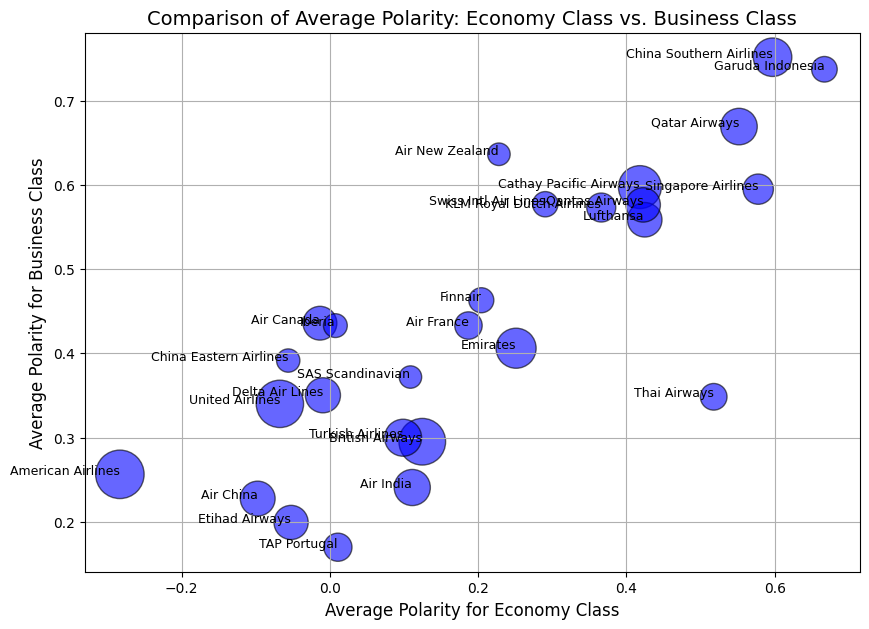

In [13]:
# Enter your code to process the customer_review data and to 
# create your word cloud visualizations

# Task 3

def plot_sentiment_comparison(df, df_review_counts):
    """
    This function creates a scatter plot to compare the average polarity values for Economy Class (x-axis) 
    and Business Class (y-axis). The size of the scatter points is determined by the number of reviews for each airline.
    
    Args:
    df (DataFrame): DataFrame containing the average polarity for Business and Economy Class for each airline.
    df_review_counts (DataFrame): DataFrame containing the total number of reviews per airline.
    """
    try:
        # Merge the polarity DataFrame with the review counts to get the total number of reviews for each airline
        df_with_counts = df.merge(df_review_counts, on='airline')
        
        # Set up the scatter plot
        plt.figure(figsize=(10, 7))
        
        # Scatter plot with review counts determining the size of the dots
        plt.scatter(
            df_with_counts['average_economy_polarity'], 
            df_with_counts['average_business_polarity'], 
            s=df_with_counts['total_reviews'] / 2,  # Scale the size of the points by total number of reviews
            alpha=0.6, 
            color='blue',
            edgecolor='black'
        )
        
        # Adding labels and title
        plt.title('Comparison of Average Polarity: Economy Class vs. Business Class', fontsize=14)
        plt.xlabel('Average Polarity for Economy Class', fontsize=12)
        plt.ylabel('Average Polarity for Business Class', fontsize=12)
        
        # Annotate each point with the airline name
        for i in range(df_with_counts.shape[0]):
            plt.text(
                df_with_counts['average_economy_polarity'].iloc[i], 
                df_with_counts['average_business_polarity'].iloc[i], 
                df_with_counts['airline'].iloc[i],
                fontsize=9,
                ha='right'
            )
        
        # Show plot
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"An error occurred while plotting: {e}")

# Assuming `df_filtered` refers to the filtered dataset used in sentiment analysis
# We need to recreate `df_filtered` from the original data to count the reviews

def calculate_review_counts(df_original):
    """
    Filters the original DataFrame to include only Business Class and Economy Class reviews, 
    then calculates the total number of reviews per airline.
    
    Args:
    df_original (DataFrame): The original dataset containing all the reviews.
    
    Returns:
    DataFrame: A DataFrame with the total review counts for each airline.
    """
    # Filter for Business and Economy class reviews
    df_filtered = df_original[df_original['cabin'].isin(['Business Class', 'Economy Class'])]

    # Count reviews per airline
    review_counts = df_filtered.groupby('airline').size().reset_index(name='total_reviews')
    
    return review_counts

# Assuming df is the original dataset, and result_df contains the average polarities for each airline
df_review_counts = calculate_review_counts(df)

# Call the plotting function with the calculated average polarity DataFrame and review counts
plot_sentiment_comparison(result_df, df_review_counts)




Stopwords already exist in project root.


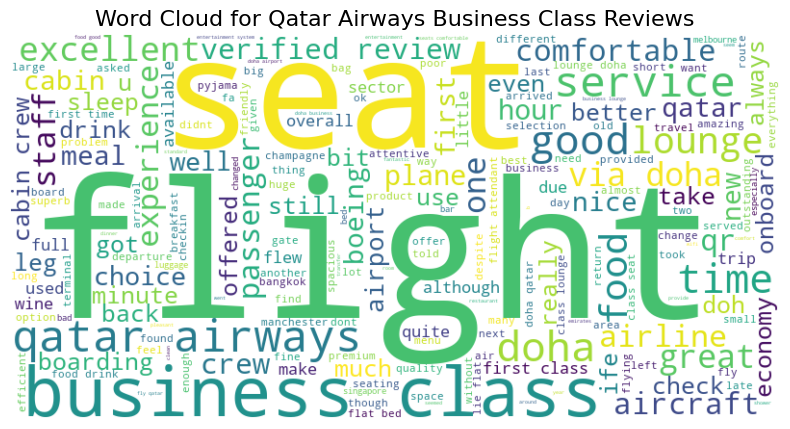

Word cloud generation process for Word Cloud for Qatar Airways Business Class Reviews completed.


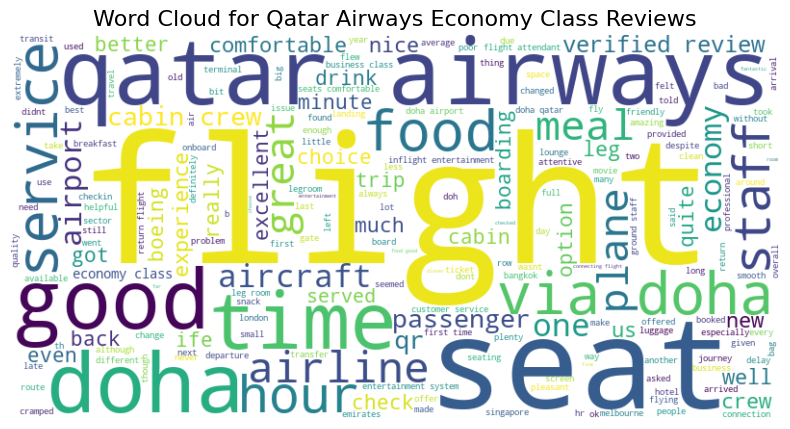

Word cloud generation process for Word Cloud for Qatar Airways Economy Class Reviews completed.


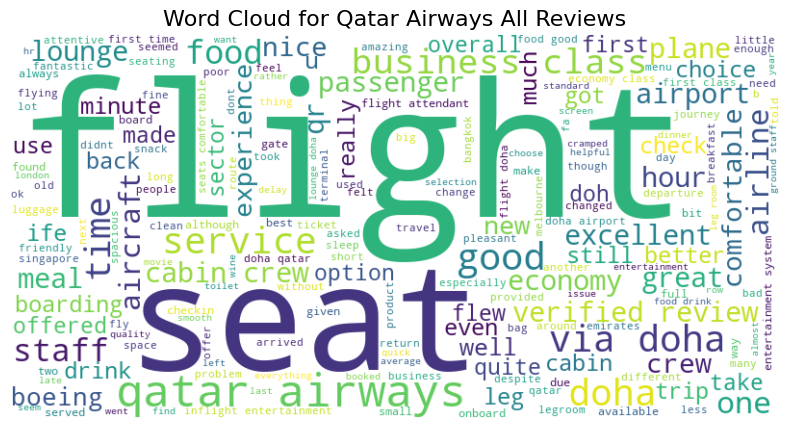

Word cloud generation process for Word Cloud for Qatar Airways All Reviews completed.
Successfully generated word clouds for Qatar Airways.
Word cloud generation process completed.


In [14]:
# Task 4 

def check_and_download_stopwords():
    """
    Checks if the stopwords corpus is already downloaded in the project root. 
    If not, downloads it and ensures it is accessible and not corrupted.
    """
    # Define the project root nltk_data path
    nltk_data_path = os.path.join(os.getcwd(), 'nltk_data')
    stopwords_path = os.path.join(nltk_data_path, 'corpora/stopwords.zip')

    try:
        # Append the custom nltk_data path
        nltk.data.path.append(nltk_data_path)

        # Check if stopwords are already downloaded
        if not os.path.exists(stopwords_path):
            print("Stopwords not found in project root. Downloading to project root...")
            nltk.download('stopwords', download_dir=nltk_data_path)
        else:
            print("Stopwords already exist in project root.")

        # Try accessing stopwords to ensure they are readable and not corrupted
        _ = stopwords.words('english')

    except Exception as e:
        print(f"Error with stopwords corpus: {e}")
        raise

def clean_review_text(review):
    """
    Cleans the review text by removing the unwanted phrase and basic preprocessing.
    """
    try:
        # Check if review is a valid string
        if not isinstance(review, str):
            raise ValueError("Review should be a string.")

        # Remove the unwanted phrase 'âœ… Trip Verified |'
        cleaned_text = re.sub(r'âœ… Trip Verified \|', '', review)

        # Convert to lowercase and remove non-alphabetic characters
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text.lower())

        # Remove stopwords
        cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stop_words])

        return cleaned_text

    except Exception as e:
        print(f"Error occurred during text cleaning: {e}")
        return ""

def generate_word_cloud(text, title):
    """
    Generates and displays a word cloud based on the provided text.
    """
    try:
        # Check if text is not empty
        if not text:
            raise ValueError("Text is empty. Cannot generate word cloud.")

        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Plotting the WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(title, fontsize=16)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error generating word cloud: {e}")
    finally:
        print(f"Word cloud generation process for {title} completed.")

def main(selected_airline):
    try:
        # Check and download stopwords
        check_and_download_stopwords()

        # Load stopwords after checking and downloading
        global stop_words
        stop_words = set(stopwords.words('english'))

        # Check if the airline is provided
        if not selected_airline:
            raise ValueError("No airline selected for analysis.")
        
        # Filter the dataset for the selected airline
        df_airline = df[df['airline'] == selected_airline]

        # Check if there are any reviews for the selected airline
        if df_airline.empty:
            raise ValueError(f"No reviews found for {selected_airline}.")

        # Separate Business Class and Economy Class reviews
        business_reviews = df_airline[df_airline['cabin'] == 'Business Class']['customer_review']
        economy_reviews = df_airline[df_airline['cabin'] == 'Economy Class']['customer_review']

        # Check if reviews exist for Business and Economy classes
        if business_reviews.empty:
            print(f"No Business Class reviews found for {selected_airline}.")
        if economy_reviews.empty:
            print(f"No Economy Class reviews found for {selected_airline}.")

        # Clean the reviews by removing the unwanted phrase and performing basic preprocessing
        business_reviews_cleaned = business_reviews.apply(clean_review_text)
        economy_reviews_cleaned = economy_reviews.apply(clean_review_text)

        # Combine all reviews (Business + Economy) using pd.concat()
        all_reviews_cleaned = pd.concat([business_reviews_cleaned, economy_reviews_cleaned])

        # Join the reviews into single strings for word cloud generation
        business_text = ' '.join(business_reviews_cleaned)
        economy_text = ' '.join(economy_reviews_cleaned)
        all_text = ' '.join(all_reviews_cleaned)

        # Generate word clouds
        if not business_reviews_cleaned.empty:
            generate_word_cloud(business_text, f'Word Cloud for {selected_airline} Business Class Reviews')
        if not economy_reviews_cleaned.empty:
            generate_word_cloud(economy_text, f'Word Cloud for {selected_airline} Economy Class Reviews')
        if not all_reviews_cleaned.empty:
            generate_word_cloud(all_text, f'Word Cloud for {selected_airline} All Reviews')

    except ValueError as ve:
        print(f"ValueError: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    else:
        print(f"Successfully generated word clouds for {selected_airline}.")
    finally:
        print("Word cloud generation process completed.")

# Select the airline for analysis (e.g., 'Qatar Airways')
selected_airline = 'Qatar Airways'

# Call the main function to generate word clouds
main(selected_airline)


## Questions

1. According your scatter plots, describe and explain the relationship of sentiment from customer's text-based reviews, through the the polarity measures, between an airline's economy class versus its business class products. Describe the statistical significance, if any, in sentiment between an airline's economy class versus its business class products.

2. Based on all the data, what airline would you primarily fly if you had to alternate between flying business and economy class? What airline would you avoid? Why?

## Responses
# 1. Describing the Relationship Between Economy and Business Class Sentiment

Looking at the scatter plot, we can clearly see that the relationship between the average sentiment (polarity) of customer reviews in **Economy Class** and **Business Class** is generally positive. This means airlines that perform well in Business Class (with higher polarity) tend to perform reasonably well in Economy Class too—but the differences are quite noticeable.

### ✈️ Clusters of Airlines:

- Many airlines hover around **neutral polarity** in both Economy and Business Class. These airlines are stuck in the "meh" zone—neither impressing nor disappointing their customers. For example, **Air India**, **Turkish Airlines**, and **Air China** hang out in this neutral territory, which means customers think their Economy and Business classes are just "okay" and nothing to write home about.

- Then, we have **Qatar Airways**, **Singapore Airlines**, and **Garuda Indonesia** dominating the positivity charts. These airlines appear in the high-polarity regions of the plot, which suggests they’re hitting the sweet spot for both Business and Economy passengers. So, if you're looking for some good vibes on your flight, these airlines are like a good cup of coffee—consistently enjoyable!

### 🥪 Economy vs. Business Sentiment:

There’s clearly a gap in sentiment between Business and Economy for most airlines. For example, **Swiss International Airlines** has quite a leap in sentiment from Economy to Business Class. It's like going from a plain cheese sandwich to a gourmet meal! Similarly, **Emirates** and **Thai Airways** show significantly better sentiment for Business Class compared to Economy. These airlines really pamper their Business Class travelers, but when it comes to Economy, well… let's just say it might feel like you’re paying for that extra legroom with your soul. 😬

### 👎 Negative Polarity:

Some airlines dip into **negative territory** for Economy Class, like **American Airlines** and **Etihad Airways**. The message here: customers aren't too thrilled with their Economy offering. **American Airlines**, in particular, seems to be a “business or bust” airline—Business Class customers are much happier, but if you’re flying Economy, pack a little patience and maybe some snacks. 🍪

---

### 📊 Statistical Significance (with a playful twist):

In statistical terms, we can’t say for sure if the differences between Business and Economy are super significant without running some fancy tests, but the gaps in sentiment suggest that many airlines prioritize their Business Class service more. So, if you ever feel like you’re being shortchanged in Economy Class—well, the scatter plot might have just confirmed your suspicions!

---

# 2. Which Airline Would You Fly? Which Would You Avoid?

### ✈️ **Fly With:**

If I were alternating between **Business** and **Economy**, my first choice would be **Qatar Airways** or **Singapore Airlines**. Why? Because both airlines score high on sentiment for **both** classes. Whether you’re kicking back in Business Class with a glass of champagne 🥂 or surviving a long-haul flight in Economy, the chances are high that you’ll land feeling pretty good (and probably refreshed!). These airlines are like the “golden retrievers” of the skies—consistent, friendly, and reliable. 🐕

### 🙅‍♂️ **Avoid:**

On the flip side, **American Airlines** seems like a bit of a gamble. While their Business Class reviews aren’t bad, their Economy sentiment is in negative territory. So, if I had to choose, I’d probably avoid them unless I was guaranteed an upgrade to Business Class (or at least a nice seat by the window!). It seems that flying Economy with them might involve a bit of turbulence—on the ground, not just in the air. 🌪️

**Etihad Airways** and **TAP Portugal** are also airlines I’d think twice about, considering their low sentiment in Economy Class. It might feel like you’re flying through the clouds of customer discontent. 😒

---

# 🎯 Conclusion:

In summary, if you’re planning to alternate between Economy and Business Class, aim for airlines that maintain a positive sentiment across the board, like **Qatar Airways** or **Singapore Airlines**. These airlines have cracked the code to keeping passengers happy, no matter the seat. 

Avoid airlines with a big gap between their Business and Economy sentiment (looking at you, **American Airlines**) unless you want your experience to feel like a flight of two extremes!

✈️ **Happy flying**, and may your next trip be smooth and full of good inflight snacks! 🍫🍹

Enter your responses here.